#### Step 1: Data Exploration and Preprocessing
- 1.1. Import libraries and data file
- 1.2. Check for null values
- 1.3. Some preprocessing

#### Step 2: Feature Engineering
- 2.1. Feature selection
- 2.2. Detect and remove outliers
- 2.3. Sanity check
- 2.4. One-hot encoding

#### Step 3: Model Selection, Training and Validation
- 3.1. Hyper-Parametrization (GridsearchCV)
- 3.2. Create price prediction function
- 3.3. Create and export pickle file
- 3.4. Export column names

#### Step 4: Model Deployment
- 4.1. Create Flask endpoint
- 4.2. Build frontend
- 4.3. Deploy on AWS

###### Data Source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

### Step 1: Data Exploration and Preprocessing

#### 1.1. Import libraries and data file

In [105]:
# 1.1. import libraries
import pandas as pd
import numpy as np
import seaborn as sns


In [106]:
# 1.1. Import data files

df_train = pd.read_csv("train.csv")
df_train.head()
# df_train["Neighborhood"].unique()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### 1.2. check for null values

In [107]:
# 1.2. check for null values on train data

def null_checker(df):
    return df.isnull().sum()

null_checker(df_train).sum() 
# shows the dataset has some null values. A sneak peak at the data shows there are some columns that 
# contain substantial amount of null values. 
# Instead of doing the null removal at this stage, it can be done post-feature selection

6965

#### 1.3. Some preprocessing

In [108]:
# 1.3. Pre-processing

#1 FullBath + HalfBath = BathRooms

def combine_full_and_half_bathrooms(df):
    df["Bathrooms"] = df["FullBath"] + (0.5*df["HalfBath"])
    df.drop(["FullBath", "HalfBath"], axis="columns")
    return df

df_train_combined = combine_full_and_half_bathrooms(df_train)
df_train_combined.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bathrooms
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,2.5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,2.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,2.5
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,2.5


### Step 2: Feature Engineering

#### 2.1. Feature selection

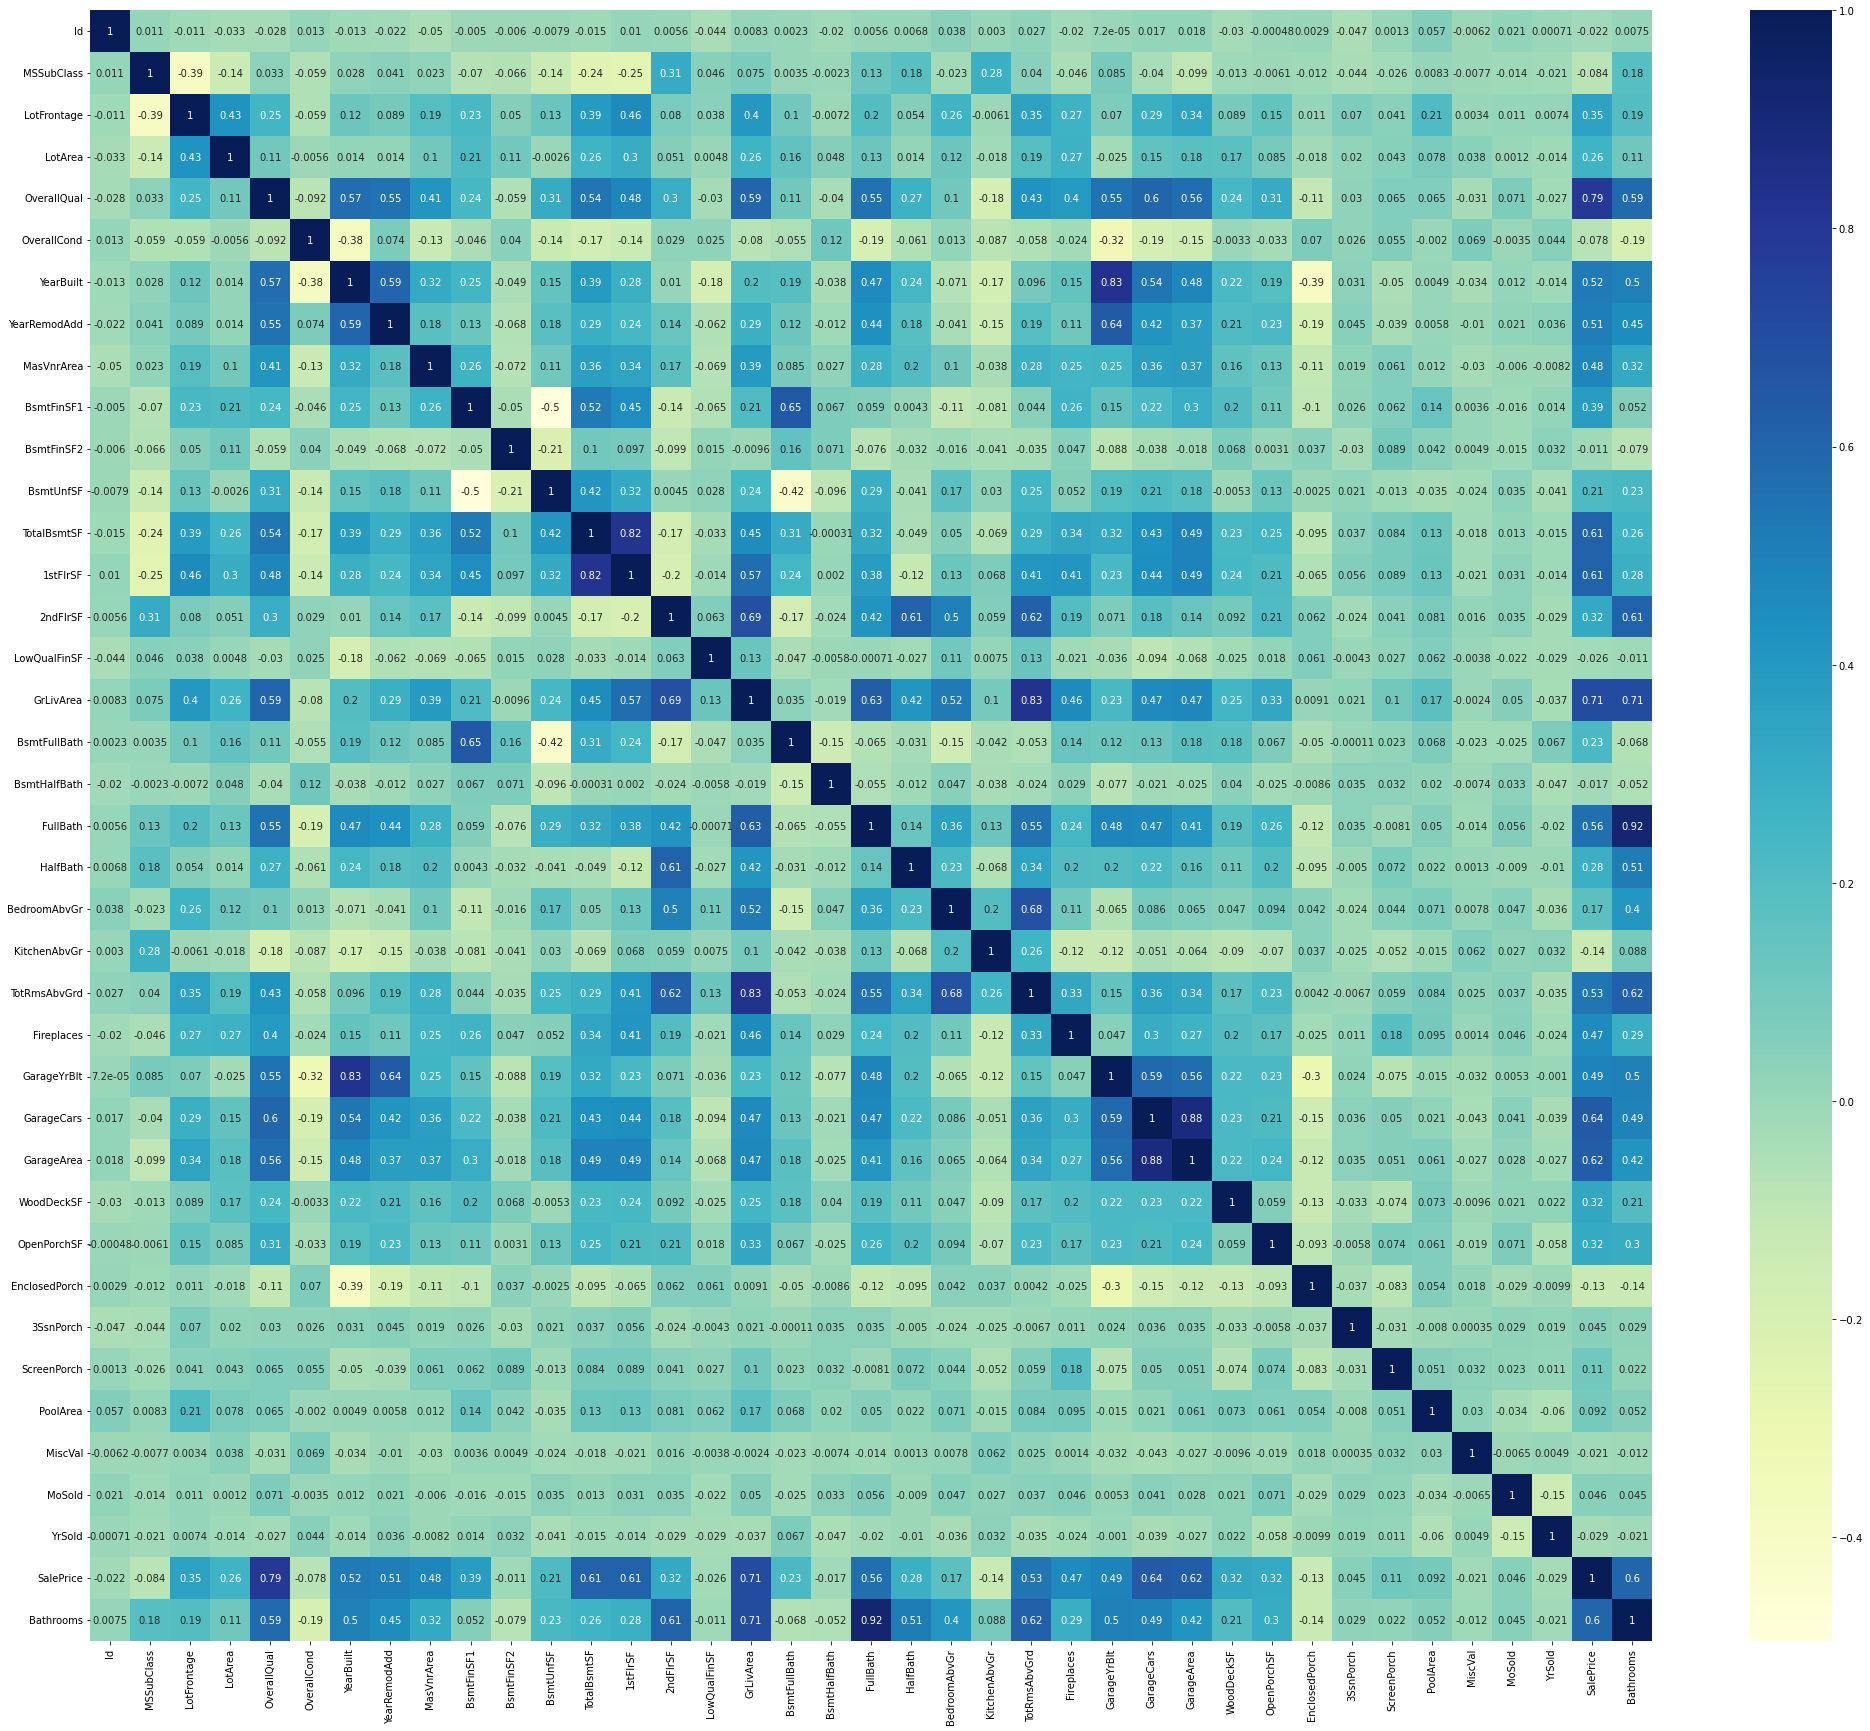

In [109]:
# 2.1. Feature selection

"""
The dataset has 81 distinct parameters. For the sake of this analysis, filtering it down to the most essential
parameters would be beneficial. The way to approach this would be to identify which numerical parameters have the highest
correlation with SalePrice which is the dependent variable in this analysis. 
The following heatmap is insightful in showing a high-level overview of the relationship
between the different numerical parameters.
"""

def correlation_heatmap(df):
    plt.figure(figsize=(35,30))
    sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")
    
correlation_heatmap(df_train_combined)

In [110]:
# we can take a more microscopic look

def highest_correlation_sorted(df, param):
    return df.corr()[param].sort_values(ascending=False)
    
highest_correlation_sorted(df_train_combined, "SalePrice")

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
Bathrooms        0.597966
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr

In [111]:
"""
Factors that have the highest correlation with SalePrice are:
OverallQual, GrLivArea GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, Bathrooms, FullBath, TotRmsAbvGrd
"""

'\nFactors that have the highest correlation with SalePrice are:\nOverallQual, GrLivArea GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF, Bathrooms, FullBath, TotRmsAbvGrd\n'

In [112]:
# Based on the previously covered explanation, the main parameters considered for this analysis are the following

selected_train_cols = ["ID", "Neighborhood", "BldgType", "OverallQual", "LotArea", "BedroomAbvGr", "Bathrooms", "GarageCars", "SalePrice"]

def filter_columns(df, list_of_cols):
    filtered_df = df.filter(list_of_cols, axis=1)
    return filtered_df

df_train_filtered = filter_columns(df_train_combined, selected_train_cols)
df_train_filtered.head()

,Neighborhood,BldgType,OverallQual,LotArea,BedroomAbvGr,Bathrooms,GarageCars,SalePrice
0,CollgCr,1Fam,7,8450,3,2.5,2,208500
1,Veenker,1Fam,6,9600,3,2.0,2,181500
2,CollgCr,1Fam,7,11250,3,2.5,2,223500
3,Crawfor,1Fam,7,9550,3,1.0,3,140000
4,NoRidge,1Fam,8,14260,4,2.5,3,250000


In [113]:
# 2.2. check for null values on train data

def null_checker(df):
    return df.isnull().sum()

null_checker(df_train_filtered) # shows we don't have null values

Neighborhood    0
BldgType        0
OverallQual     0
LotArea         0
BedroomAbvGr    0
Bathrooms       0
GarageCars      0
SalePrice       0
dtype: int64

#### 2.2. Detect and remove outliers

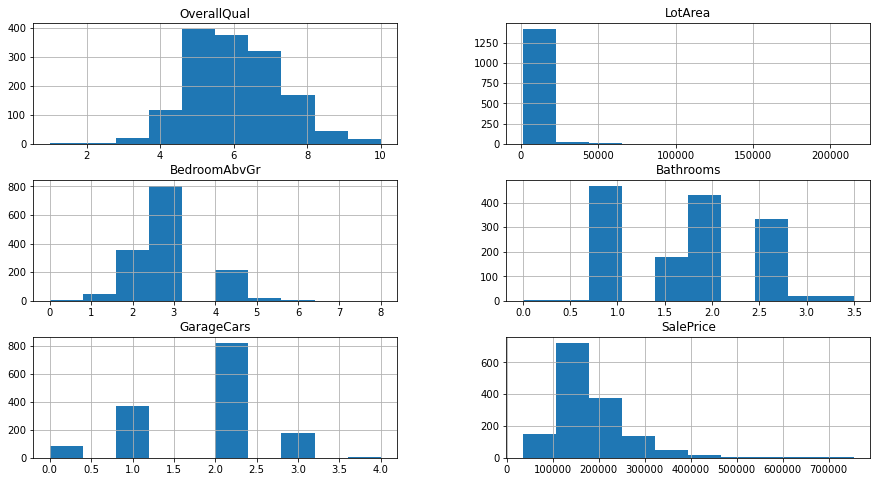

In [114]:
# leveraging visualiser to see distribution of data values
def histogram_visualiser(df):
    df.hist(figsize=(15,8))

histogram_visualiser(df_train_filtered)

array([[<AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'LotArea'}>],
       [<AxesSubplot:title={'center':'BedroomAbvGr'}>,
        <AxesSubplot:title={'center':'Bathrooms'}>],
       [<AxesSubplot:title={'center':'GarageCars'}>,
        <AxesSubplot:title={'center':'SalePrice'}>]], dtype=object)

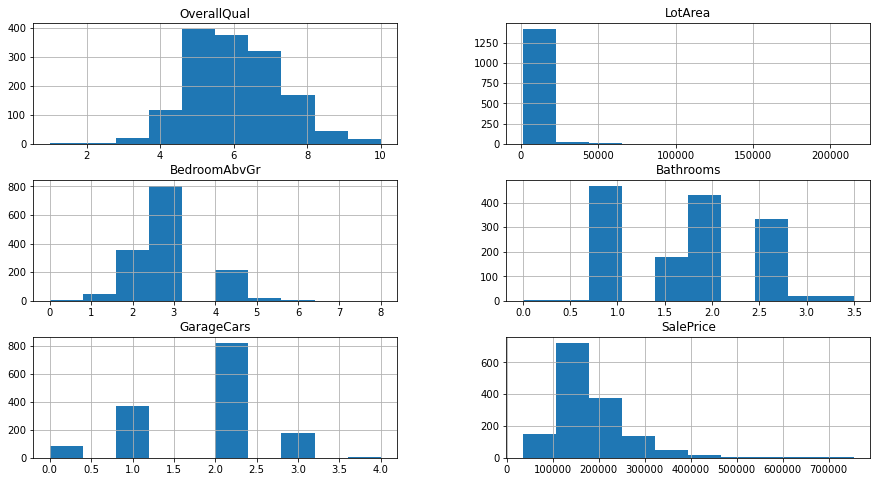

In [130]:
# leveraging visualiser to see if outlier removal was successful
df_train_filtered.hist(figsize=(15,8))

#### 2.3. Sanity check

In [131]:
# Sanity check, final cleanup
#1. Remove houses that have less than 1 BedroomAbvGr
def row_remover_based_on_min_value(df, param, min_value):
    df_out = pd.DataFrame()
    df_out = df[df[param] >= min_value] #only keeps datapoints that are greater than or equal to cutoff value
    return df_out

def row_remover_based_on_max_value(df, param, max_value):
    df_out = pd.DataFrame()
    df_out = df[df[param] <= max_value] #only keeps datapoints that are less than or equal to cutoff value
    return df_out

#2. Remove houses with less than 1 Bathroom
df_train_no_outlier1 = row_remover_based_on_min_value(df_train_filtered, "Bathrooms", 1)

#3. Remove houses that have less than 1 BedroomAbvGr
df_train_clean = row_remover_based_on_min_value(df_train_no_outlier1, "BedroomAbvGr", 1)


df_train_clean.head()

,Neighborhood,BldgType,OverallQual,LotArea,BedroomAbvGr,Bathrooms,GarageCars,SalePrice
0,CollgCr,1Fam,7,8450,3,2.5,2,208500
1,Veenker,1Fam,6,9600,3,2.0,2,181500
2,CollgCr,1Fam,7,11250,3,2.5,2,223500
3,Crawfor,1Fam,7,9550,3,1.0,3,140000
4,NoRidge,1Fam,8,14260,4,2.5,3,250000


In [132]:
# 2.4. One-hot encoding
"""
The columns that will be one-hot encoded are the Neighbourhood and BldgType columns.
To avoid the "cure of dimensionality", let's look at how many unique values each column has
"""

'\nThe columns that will be one-hot encoded are the Neighbourhood and BldgType columns.\nTo avoid the "cure of dimensionality", let\'s look at how many unique values each column has\n'

In [133]:
# unique values
print("Neighbourhood - unique values:", len(df_train_clean["Neighborhood"].unique()))
print("BldgType - unique values:", len(df_train_clean["BldgType"].unique()))

Neighbourhood - unique values: 25
BldgType - unique values: 5


In [134]:
"""
Reducing the unique values in Neighbourhood will have a positive effect on the accuracy of ml models
"""

def top_10_count_modify_dataframe(df, neighborhood_col_name):
    # calculate frequency of each neighborhood
    counts = df[neighborhood_col_name].value_counts()

    # get top 10 neighborhoods
    top10 = counts[:10].index.tolist()

    # replace other neighborhoods with "Other"
    df.loc[~df[neighborhood_col_name].isin(top10), neighborhood_col_name] = 'Other'
    
    return df

df_train_clean_less_dim = top_10_count_modify_dataframe(df_train_clean, "Neighborhood")
print(df_train_clean_less_dim["Neighborhood"].unique())
print(len(df_train_clean_less_dim["Neighborhood"].unique()))

['CollgCr' 'Other' 'Somerst' 'NWAmes' 'OldTown' 'Sawyer' 'NridgHt' 'NAmes'
 'SawyerW' 'Edwards' 'Gilbert']
11


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [135]:
print(df_train_clean_less_dim.shape)

(1452, 8)


In [136]:
df_temp = remove_outliers(df_train_clean_less_dim)
df_temp.shape

C:\Users\User\AppData\Local\Temp/ipykernel_28944/1423976926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_Per_Sq_Ft"] = df["SalePrice"] / df["LotArea"]


(1359, 9)

In [137]:
# outlier removal based on Neighbourhood
import numpy as np
from scipy.stats import skew, zscore

def create_price_per_sq_ft(df):
    df["Price_Per_Sq_Ft"] = df["SalePrice"] / df["LotArea"]
    return df

def remove_col(df, col):
    df = df.drop(col, axis="columns")
    return df

def remove_outliers(df, z_thresh=2, skew_thresh=1):
    exclude_indices = np.array([])
    df = create_price_per_sq_ft(df)
    # df = remove_col(df, "SalePrice")
    
    # Group the data by neighborhood and then by bedroomAbvGr
    for (neighborhood, bedroomAbvGr), group in df.groupby(["Neighborhood", "BedroomAbvGr"]):
        # Calculate skewness of Price_Per_Sq_Ft column within each neighborhood and bedroomAbvGr group
        skewness = skew(group["Price_Per_Sq_Ft"])
        
        # Calculate z-scores of Price_Per_Sq_Ft column within each neighborhood and bedroomAbvGr group
        z_scores = zscore(group["Price_Per_Sq_Ft"])
        
        # Calculate modified z-scores based on skewness
        mod_z_scores = (group["Price_Per_Sq_Ft"] - group["Price_Per_Sq_Ft"].median()) / (1.4826 * np.median(abs(group["Price_Per_Sq_Ft"] - group["Price_Per_Sq_Ft"].median())))
        #mod_z_scores = (group["SalePrice"] - group["SalePrice"].median()) / (1.4826 * np.median(abs(group["SalePrice"] - group["SalePrice"].median())))

        # Exclude rows with z-scores or modified z-scores greater than z_thresh
        if skewness >= skew_thresh:
            exclude_indices = np.append(exclude_indices, group[mod_z_scores > z_thresh].index.values)
        else:
            exclude_indices = np.append(exclude_indices, group[abs(z_scores) > z_thresh].index.values)
    
    # Drop excluded rows and return new DataFrame
    return df.drop(exclude_indices, axis="index")

df_train_no_outliers = remove_outliers(df_train_clean)
df_train_no_outliers.head()

C:\Users\User\AppData\Local\Temp/ipykernel_28944/1423976926.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_Per_Sq_Ft"] = df["SalePrice"] / df["LotArea"]


,Neighborhood,BldgType,OverallQual,LotArea,BedroomAbvGr,Bathrooms,GarageCars,SalePrice,Price_Per_Sq_Ft
0,CollgCr,1Fam,7,8450,3,2.5,2,208500,24.674556
1,Other,1Fam,6,9600,3,2.0,2,181500,18.906250
2,CollgCr,1Fam,7,11250,3,2.5,2,223500,19.866667
3,Other,1Fam,7,9550,3,1.0,3,140000,14.659686
4,Other,1Fam,8,14260,4,2.5,3,250000,17.531557


In [138]:
df_train_no_outliers.to_csv("final_data.csv", index=False)

#### 2.4. One-hot encoding

In [141]:
def one_hot_encoder(df, columns_to_be_encoded):
    dummy_encoded = [df]
    for col in columns_to_be_encoded:
        pd_dummy = pd.get_dummies(df[col])
        dummy_encoded.append(pd_dummy)
    df_encoded = pd.DataFrame()
    df_encoded = pd.concat(dummy_encoded, axis="columns")
    df_encoded = df_encoded.drop(columns_to_be_encoded, axis="columns")
    return df_encoded

df_train_encoded = one_hot_encoder(df_train_no_outliers, ["Neighborhood", "BldgType"])
print(df_train_encoded.columns)
print(df_train_encoded.shape)

Index(['OverallQual', 'LotArea', 'BedroomAbvGr', 'Bathrooms', 'GarageCars',
       'SalePrice', 'Price_Per_Sq_Ft', 'CollgCr', 'Edwards', 'Gilbert',
       'NAmes', 'NWAmes', 'NridgHt', 'OldTown', 'Other', 'Sawyer', 'SawyerW',
       'Somerst', '1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
      dtype='object')
(1359, 23)


In [142]:
# Remove "Other" column
def drop_col(df, list_of_col):
    df_out = df.drop(list_of_col, axis="columns")
    return df_out

df_train_encoded2 = drop_col(df_train_encoded, ["Other"])
df_train_encoded2.head()


,OverallQual,LotArea,BedroomAbvGr,Bathrooms,GarageCars,SalePrice,Price_Per_Sq_Ft,CollgCr,Edwards,Gilbert,...,NridgHt,OldTown,Sawyer,SawyerW,Somerst,1Fam,2fmCon,Duplex,Twnhs,TwnhsE
0,7,8450,3,2.5,2,208500,24.674556,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,6,9600,3,2.0,2,181500,18.906250,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,7,11250,3,2.5,2,223500,19.866667,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,9550,3,1.0,3,140000,14.659686,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,8,14260,4,2.5,3,250000,17.531557,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [143]:
# let's split the dataset into independent and dependent variables

X = df_train_encoded2.drop(["Price_Per_Sq_Ft", "SalePrice"], axis="columns")
y = df_train_encoded2["Price_Per_Sq_Ft"]
# print(X.head())
# print(y.head())

### Step 3: Model Selection, Training and Validation

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [145]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

0.7077087867210605

#### 3.1. Hyper-Parametrization (GridsearchCV)

In [164]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

def hyperparameter_tuning(X, y):
    # define regression models to test
    models = {'Linear Regression': LinearRegression(),
              'Ridge': Ridge(),
              'Lasso': Lasso(),
              'Decision Tree': DecisionTreeRegressor()}

    # define hyperparameters to test for each model
    params = {'Linear Regression': {'normalize': [True, False]},
              'Ridge': {'alpha': [0.01, 0.1, 1, 10]},
              'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
              'Decision Tree': {'max_depth': [2, 4, 6, 8]}}

    # perform grid search with ShuffleSplit cross-validation for each model and store results in a DataFrame
    scores = []
    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
        grid_search = GridSearchCV(model, param_grid=params[model_name], cv=cv)
        grid_search.fit(X, y)
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_
        y_pred = grid_search.predict(X)
        r2 = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        scores_cv = cross_val_score(grid_search, X, y, cv=cv, scoring='r2')
        mean_cv_score = scores_cv.mean()
        std_cv_score = scores_cv.std()
        scores.append((model_name, best_score, best_params, r2, mse, mean_cv_score, std_cv_score))

    # return scores as a DataFrame
    scores_df = pd.DataFrame(scores, columns=["model", "best_score", "best_params", "R2_score", "MSE", "CV_R2_mean", "CV_R2_std"])
    return scores_df

hyperparameter_tuning(X,y)

,model,best_score,best_params,R2_score,MSE,CV_R2_mean,CV_R2_std
0,Linear Regression,0.652816,{'normalize': False},0.711435,27.475010,0.652852,0.025928
1,Ridge,0.652800,{'alpha': 0.01},0.711435,27.475013,0.652800,0.026522
2,Lasso,0.653052,{'alpha': 0.01},0.710914,27.524632,0.653052,0.026234
3,Decision Tree,0.748848,{'max_depth': 8},0.914051,8.183462,0.729547,0.043038


In [165]:
from sklearn.tree import DecisionTreeRegressor

# Split the data into training and testing sets using train_test_split function
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree regressor with the best hyperparameters
# Here, we are using the max_depth hyperparameter value that gave the best score during hyperparameter tuning
dt = DecisionTreeRegressor(max_depth=8)

# Fit the Decision Tree regressor on the training data
dt.fit(X_train, y_train)

# Make predictions on the testing data using the trained Decision Tree model
y_pred = dt.predict(X_test)

# Evaluate the performance of the model on the testing data
from sklearn.metrics import r2_score, mean_squared_error
print('R2 Score:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))


R2 Score: 0.7794752969371375
MSE: 16.845704844333714


In [166]:
df_train_no_outliers.columns

Index(['Neighborhood', 'BldgType', 'OverallQual', 'LotArea', 'BedroomAbvGr',
       'Bathrooms', 'GarageCars', 'SalePrice', 'Price_Per_Sq_Ft'],
      dtype='object')

In [160]:
df_train_no_outliers.head(10)

,Neighborhood,BldgType,OverallQual,LotArea,BedroomAbvGr,Bathrooms,GarageCars,SalePrice,Price_Per_Sq_Ft
0,CollgCr,1Fam,7,8450,3,2.5,2,208500,24.674556
1,Other,1Fam,6,9600,3,2.0,2,181500,18.906250
2,CollgCr,1Fam,7,11250,3,2.5,2,223500,19.866667
3,Other,1Fam,7,9550,3,1.0,3,140000,14.659686
4,Other,1Fam,8,14260,4,2.5,3,250000,17.531557
5,Other,1Fam,5,14115,1,1.5,2,143000,10.131066
6,Somerst,1Fam,8,10084,3,2.0,2,307000,30.444268
7,NWAmes,1Fam,7,10382,3,2.5,2,200000,19.264111
8,OldTown,1Fam,7,6120,2,2.0,2,129900,21.225490
9,Other,2fmCon,5,7420,2,1.0,1,118000,15.902965


#### 3.2. Create price prediction function

In [161]:
def predict_price(Neighborhood, BldgType, OverallQual, LotArea, BedroomAbvGr, Bathrooms, GarageCars):
    """
    Function to make price predictions using the trained Decision Tree model.
    The input variables should be passed as separate arguments in the following order:
    Neighborhood, BldgType, OverallQual, LotArea, BedroomAbvGr, Bathrooms, GarageCars.
    """
    # Create a numpy array with the input data
    x = np.zeros(len(X.columns))
    x[0] = LotArea
    x[1] = OverallQual
    x[2] =  BedroomAbvGr
    x[3] = Bathrooms
    x[4] = GarageCars
    
    # Find the index of the neighborhood and building type in the feature matrix
    neighborhood_index = np.where(X.columns == Neighborhood)[0][0]
    bldgtype_index = np.where(X.columns == BldgType)[0][0]
    
    # Set the values for the neighborhood and building type columns to 1
    if neighborhood_index >= 0:
        x[neighborhood_index] = 1
    if bldgtype_index >= 0:
        x[bldgtype_index] = 1
    
    # Make price predictions using the trained Decision Tree model
    return dt.predict([x])[0]


In [162]:
predict_price("CollgCr", "1Fam", 7, 8450, 3, 2.5, 2)

32.79320987654321

In [163]:
predict_price("Somerst", "1Fam", 8, 10084, 3, 2.0, 2)

32.79320987654321

In [162]:
predict_price2("BrDale", "1Fam", 5, 6120, 2, 2.0, 2)

60.33940917661848

#### 3.3. Create and export pickle file


In [147]:
# 3.3. Create and export pickle file
import pickle
with open("final_house_prices_model1.pickle", "wb") as f:
    pickle.dump(dt, f)

#### 3.4. Export column names

In [148]:
# 3.5. Export column names
import json
columns = {
    "data_columns": [column.lower() for column in X.columns]
}
with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [149]:
X.columns

Index(['OverallQual', 'LotArea', 'BedroomAbvGr', 'Bathrooms', 'GarageCars',
       'CollgCr', 'Edwards', 'Gilbert', 'NAmes', 'NWAmes', 'NridgHt',
       'OldTown', 'Sawyer', 'SawyerW', 'Somerst', '1Fam', '2fmCon', 'Duplex',
       'Twnhs', 'TwnhsE'],
      dtype='object')